# Percentile calculation for the PSD/ASD (a measure of spectral uncertainty)


Authors: Pooya Saffarieh <p.saffarieh@nikhefDOTnl>, Artem Basalaev <artemDOTbasalaev@pmDOTme>

The example demonstrates how functionalities already present in GWpy, and by extension available in Spicypy, can be used to infer a measure of uncertainty of a spectrum.

If not done already, install spicypy (uncomment the line below):

In [1]:
#pip install spicypy

Imports:

In [2]:
from gwpy.timeseries import TimeSeries
import numpy as np
from gwpy.plot import Plot
import matplotlib.pyplot as plt
from scipy.stats import rayleigh
from pandas import read_csv

Define time series and averaging parameters:

In [3]:
window_length   = 5      # windown_length for each FFT in seconds
sampling_rate   = 100    # Sampling rate in Hz
window_function = 'hann' # Window used for the FFT
overlap_sec     = 0      # Overlaping the windows in seconds. 

## Compare 95-percentile band of seismic data and white noise

Load seismic data and create white noise sample for comparison

In [4]:
# Night seismic data from two different seismometer 1m apart from each other. East, North, Vertical - unit: m/s
data = read_csv("seismic_data/seismic_data_2023-05-17T01_00_00-2023-05-17T02_00_00_TH120.zip", index_col=0)
# Creating timeseries object for each coloumn. 
data1_east     = TimeSeries(data["east"].to_numpy(),sample_rate=sampling_rate,unit='m/s')
data1_north    = TimeSeries(data["north"].to_numpy(),sample_rate=sampling_rate,unit='m/s')
data1_vertical = TimeSeries(data["vertical"].to_numpy(),sample_rate=sampling_rate,unit='m/s')

In [5]:
# A sample white_noise with similar length and standard deviation. Just for comparison and validation of the method.
white_noise    = TimeSeries(np.random.normal(0, np.std(data1_east.value), len(data1_east)), sample_rate = sampling_rate, unit='m/s')

Use `spectrogram2` to calculate a spectrogram, i.e. an object containing non-averaged FFTs in all windows. The averaged median value ("regular" ASD) can then be calculated using `.percentile(50)`, and the uncertainty band using `percentile(5)` and `percentile(59)`, respectively.

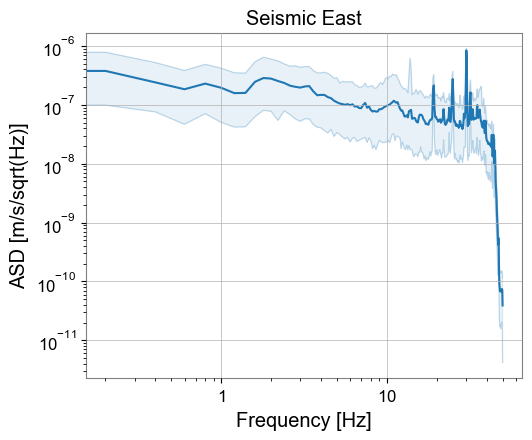

In [6]:
# Spectogram2() returns an array with shape (number_of_windows, number_of_freq_bins_in_that_window)
data1_east_asd = data1_east.spectrogram2(fftlength=window_length, overlap=overlap_sec, window=window_function) ** (1 / 2.)

# Calculating percentiles for each frequency bin.
median         = data1_east_asd.percentile(50)
low            = data1_east_asd.percentile(5)
high           = data1_east_asd.percentile(95)

plot = Plot()
ax   = plot.add_subplot(xlabel='Frequency [Hz]',ylabel='ASD [m/s/sqrt(Hz)]',xscale='log',yscale='log', title='Seismic East')
_ = ax.plot_mmm(median, low, high)

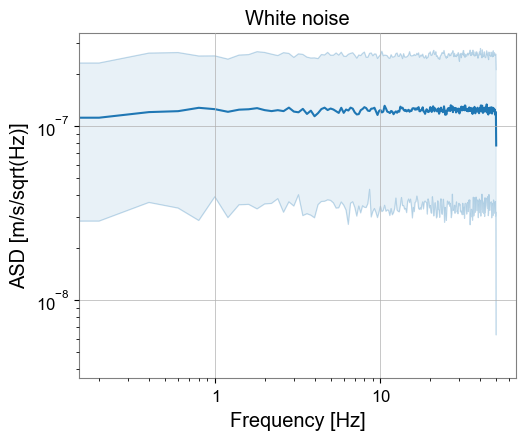

In [7]:
white_noise_asd = white_noise.spectrogram2(fftlength=window_length, overlap= overlap_sec, window=window_function) ** (1 / 2.)

median         = white_noise_asd.percentile(50)
low            = white_noise_asd.percentile(5)
high           = white_noise_asd.percentile(95)

plot = Plot()
ax   = plot.add_subplot(xlabel='Frequency [Hz]',ylabel='ASD [m/s/sqrt(Hz)]',xscale='log',yscale='log',title='White noise')
_ = ax.plot_mmm(median, low, high)

## Compare histograms of a frequency bin

Plot histograms containing all amplitudes of the spectrogram at a specific frequency, 20 Hz in this example. The resulting distribution should approximate Rayleigh distribution pdf, which is demonstrated below by fitting it with the Rayleigh propability density.

resolution: 0.199203187250996
bin number: 100
number of freq bins: 720


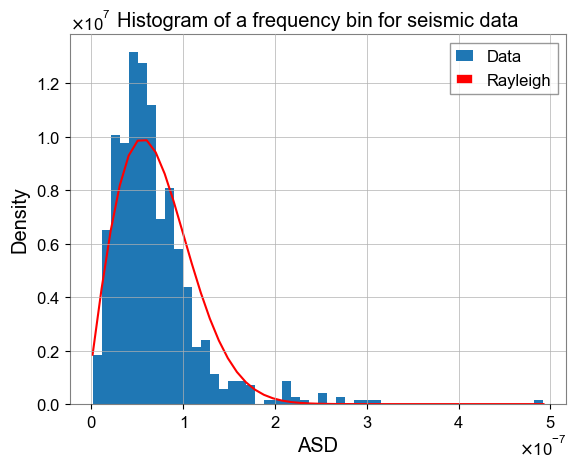

In [8]:
# Calculating the resolution of the FFT 
resolution = (sampling_rate / 2) / data1_east_asd.shape[1]
print(f'resolution: {resolution}')

required_frequency = 20
bin_number = int(required_frequency / resolution)
print(f'bin number: {bin_number}')

# Selecting the bin which we want to see the distribution for
freqs = data1_east_asd[:, bin_number]
print(f'number of freq bins: {len(freqs)}')

# Fitting a rayleigh distribution for the freqs.
loc, scale = rayleigh.fit(freqs)

# Returns (y,x) for histogram plot.
histogram = plt.hist(freqs, bins=50,density=True,label='Data')

# geting y valuess for fitted PDF for given x axis points.
test_rayleigh_pdf = rayleigh.pdf(histogram[1],loc=loc, scale = scale)

plt.plot(histogram[1], test_rayleigh_pdf, color='r',label='Rayleigh')
plt.title('Histogram of a frequency bin for seismic data')
plt.xlabel('ASD')
plt.ylabel('Density')
plt.legend()

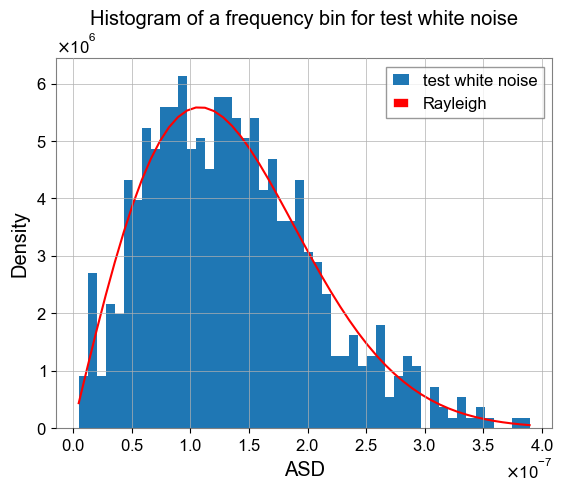

In [9]:
required_frequency = 20

freqs = white_noise_asd[:,int(required_frequency / resolution)]

# Fitting a rayleigh distribution for the freqs.
loc, scale = rayleigh.fit(freqs)

# Returns (y,x) for histogram plot.
histogram = plt.hist(freqs, bins=50,density=True,label='test white noise')

# geting y valuess for fitted PDF for given x axis points.
test_rayleigh_pdf = rayleigh.pdf(histogram[1],loc=loc, scale = scale)

plt.plot(histogram[1], test_rayleigh_pdf, color='r',label='Rayleigh')
plt.title('Histogram of a frequency bin for test white noise')
plt.xlabel('ASD')
plt.ylabel('Density')
plt.legend()